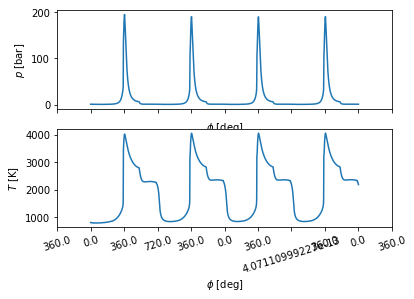

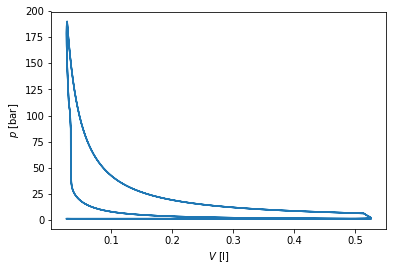

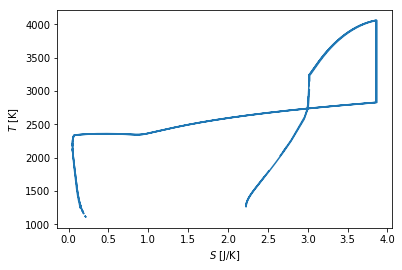

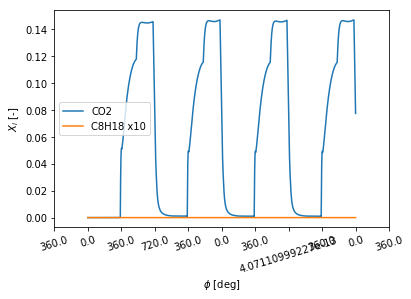

Heat release rate per cylinder (estimate):	 52.6 kW
Expansion power per cylinder (estimate):	 23.6 kW
Efficiency (estimate):			 44.9 %
CO emission (estimate):		 21406.5 ppm


<Figure size 432x288 with 0 Axes>

In [66]:
# -*- coding: utf-8 -*-
"""
Simulation of a (gaseous) Diesel-type internal combustion engine.
"""

import cantera as ct
import numpy as np

#######################################################################
# Input Parameters
#######################################################################

f = 3000. / 60.  # engine speed [1/s] (3000 rpm)
V_H = .5e-3  # displaced volume [m**3]
epsilon = 20.  # compression ratio [-]
d_piston = 0.083  # piston diameter [m]

# turbocharger temperature, pressure, and composition
T_inlet = 800.  # K
p_inlet = 1.3e5  # Pa
comp_inlet = 'N2O:1'

# outlet pressure
p_outlet = 1.2e5  # Pa

# fuel properties (gaseous!)
T_injector = 300.  # K
p_injector = 1600e5  # Pa
comp_injector = 'C3H8:1'

# ambient properties
T_ambient = 300.  # K
p_ambient = 1e5  # Pa
comp_ambient = 'O2:1, N2:3.76'

# Reaction mechanism name
reaction_mechanism = 'gri3022.cti'

# Inlet valve friction coefficient, open and close timings
inlet_valve_coeff = 1.e-6
inlet_open = -18. / 180. * np.pi
inlet_close = 198. / 180. * np.pi

# Outlet valve friction coefficient, open and close timings
outlet_valve_coeff = 1.e-6
outlet_open = 522. / 180 * np.pi
outlet_close = 18. / 180. * np.pi

# Fuel mass, injector open and close timings
injector_open = 350. / 180. * np.pi
injector_close = 365. / 180. * np.pi
injector_mass = 3.2e-5  # kg
injector_t_open = (injector_close - injector_open) / 2. / np.pi / f

# Simulation time and resolution
sim_n_revolutions = 8.
sim_n_timesteps = 100000.

###################################################################

# load reaction mechanism
gas = ct.Solution(reaction_mechanism)

# define initial state
gas.TPX = T_inlet, p_inlet, comp_inlet
r = ct.IdealGasReactor(gas)
# define inlet state
gas.TPX = T_inlet, p_inlet, comp_inlet
inlet = ct.Reservoir(gas)
# define injector state (gaseous!)
gas.TPX = T_injector, p_injector, comp_injector
injector = ct.Reservoir(gas)
# define outlet pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_outlet, comp_ambient
outlet = ct.Reservoir(gas)
# define ambient pressure (temperature and composition don't matter)
gas.TPX = T_ambient, p_ambient, comp_ambient
ambient_air = ct.Reservoir(gas)

# set up connecting devices
inlet_valve = ct.Valve(inlet, r)
injector_mfc = ct.MassFlowController(injector, r)
outlet_valve = ct.Valve(r, outlet)
piston = ct.Wall(ambient_air, r)

# convert time to crank angle
def crank_angle(t):
    return np.remainder(2 * np.pi * f * t, 4 * np.pi)

# set up IC engine parameters
V_oT = V_H / (epsilon - 1.)
A_piston = .25 * np.pi * d_piston ** 2
stroke = V_H / A_piston
r.volume = V_oT
piston.area = A_piston
def piston_speed(t):
    return - stroke / 2 * 2 * np.pi * f * np.sin(crank_angle(t))
piston.set_velocity(piston_speed)

# create a reactor network containing the cylinder
sim = ct.ReactorNet([r])

# set up output data arrays
states = ct.SolutionArray(r.thermo)
t_sim = sim_n_revolutions / f
t = (np.arange(sim_n_timesteps) + 1) / sim_n_timesteps * t_sim
V = np.zeros_like(t)
m = np.zeros_like(t)
test = np.zeros_like(t)
mdot_in = np.zeros_like(t)
mdot_out = np.zeros_like(t)
d_W_v_d_t = np.zeros_like(t)
heat_release_rate = np.zeros_like(t)

# set parameters for the automatic time step refinement
n_last_refinement = -np.inf  # for initialization only
n_wait_coarsening = 10

# do simulation
for n1, t_i in enumerate(t):
    # define opening and closing of valves and injector
    if (np.mod(crank_angle(t_i) - inlet_open, 4 * np.pi) <
            np.mod(inlet_close - inlet_open, 4 * np.pi)):
        inlet_valve.set_valve_coeff(inlet_valve_coeff)
        test[n1] = 1
    else:
        inlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - outlet_open, 4 * np.pi) <
            np.mod(outlet_close - outlet_open, 4 * np.pi)):
        outlet_valve.set_valve_coeff(outlet_valve_coeff)
    else:
        outlet_valve.set_valve_coeff(0)
    if (np.mod(crank_angle(t_i) - injector_open, 4 * np.pi) <
            np.mod(injector_close - injector_open, 4 * np.pi)):
        injector_mfc.set_mass_flow_rate(injector_mass / injector_t_open)
    else:
        injector_mfc.set_mass_flow_rate(0)

    # perform time integration, refine time step if necessary
    for n2 in range(4):
        if n2 is 4:
            raise 'Error: Refinement limit reached'
        try:
            sim.advance(t_i)
        except Exception:
            sim.set_max_time_step(1e-6 * 10. ** -n2)
            n_last_refinement = n1
    # coarsen time step if too long ago
    if n1 - n_last_refinement is n_wait_coarsening:
        sim.set_max_time_step(1e-5)

    # write output data
    states.append(r.thermo.state)
    V[n1] = r.volume
    m[n1] = r.mass
    mdot_in[n1] = inlet_valve.mdot(0)
    mdot_out[n1] = outlet_valve.mdot(0)
    d_W_v_d_t[n1] = - (r.thermo.P - ambient_air.thermo.P) * A_piston * \
        piston_speed(t_i)
    heat_release_rate[n1] = - r.volume * ct.gas_constant * r.T * \
        np.sum(gas.standard_enthalpies_RT * r.thermo.net_production_rates, 0)


#####################################################################
# Plot Results in matplotlib
#####################################################################

import matplotlib.pyplot as plt

# pressure and temperature
plt.clf()
plt.subplot(211)
plt.plot(t, states.P / 1.e5)
plt.ylabel('$p$ [bar]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], [])
plt.subplot(212)
plt.plot(t, states.T)
plt.ylabel('$T$ [K]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180 / np.pi,
           rotation=17)
plt.show()
plt.savefig('ic_engine_t_p_T.png')

# p-V diagram
plt.clf()
plt.plot(V[t > 0.04] * 1000, states.P[t > 0.04] / 1.e5)
plt.xlabel('$V$ [l]')
plt.ylabel('$p$ [bar]')
plt.show()
plt.savefig('ic_engine_p_V.png')

# T-S diagram
plt.clf()
plt.plot(m[t > 0.04] * states.s[t > 0.04], states.T[t > 0.04])
plt.xlabel('$S$ [J/K]')
plt.ylabel('$T$ [K]')
plt.show()
plt.savefig('ic_engine_T_S.png')


# gas composition
plt.clf()
#plt.plot(t, states('O2').X, label='O2')
#plt.plot(t, states('N2O').X, label='N2O')
#plt.plot(t, states('N2').X, label='N2')
plt.plot(t, states('CO2').X, label='CO2')
#plt.plot(t, states('CO').X, label='CO')
plt.plot(t, states('C8H18').X * 10, label='C8H18 x10')
plt.legend(loc=0)
plt.ylabel('$X_i$ [-]')
plt.xlabel('$\phi$ [deg]')
plt.xticks(plt.xticks()[0], crank_angle(plt.xticks()[0]) * 180 / np.pi,
           rotation=17)
plt.show()
plt.savefig('ic_engine_t_X.png')


#####################################################################
# Integral Results
#####################################################################

from scipy.integrate import trapz
Q = trapz(heat_release_rate, t)
W = trapz(d_W_v_d_t, t)
eta = W / Q
MW = states.mean_molecular_weight
CO_emission = trapz(MW * mdot_out * states('CO').X[:,0], t) / trapz(MW * mdot_out, t)
print('Heat release rate per cylinder (estimate):\t' +
      format(Q / t_sim / 1000., ' 2.1f') + ' kW')
print('Expansion power per cylinder (estimate):\t' +
      format(W / t_sim / 1000., ' 2.1f') + ' kW')
print('Efficiency (estimate):\t\t\t' + format(eta * 100., ' 2.1f') + ' %')
print('CO emission (estimate):\t\t' + format(CO_emission * 1.e6, ' 2.1f') +
      ' ppm')
print('p_max:'+max(states.P/10e4)+'bar')
print('T_max:'+max(states.T)+'K')

In [67]:
max(states.P/10e4)



194.62715134025152

max(states.T)

In [68]:
max(states.T)

4060.6199124224927